<img src="media/coco-banner.jpg">

# Xarray

[_Xarray_](https://docs.xarray.dev/) is a Python package that makes working with labelled multi-dimensional arrays (like stacks of images) in Python simple, efficient, and fun. It has extensions for specific domains, for example the [Rioxarray](https://corteva.github.io/rioxarray) adds functionality for geospatial raster data. The name "RIO" comes from "RasterIO"(Input/Output), because the extension makes use of yet another great open source package [RasterIO](https://rasterio.readthedocs.io).   

We will learn about:
* How to open a satellite image
* How to extract quantitative data from geospatial coordinates
* How to save an image for GIS software like [QGIS](https://www.qgis.org/)
* Plots
* How to scale analysis with *lots* of images using [Microsoft's Planetary Computer](https://planetarycomputer.microsoft.com/)

---

Xarray hace que trabajar con datos n-dimensionales (conjuntos de imagenes) sea sencillo, eficaz, y divertido! Tiene extenciones para varios dominios cientificos, por ejemplo Rioxarray aggrega funciones para trabajar con datos cuadriculares geospaciales (imagenes de satellite) comun en geociencias. El nombre 'RIO' viene de "RasterIO" (IO = Input/Output), porque la extencion utiliza otro paquete libre en Python: RasterIO.

## Import Xarray | Importar Xarrray

In [1]:
import xarray as xr
xr.__version__

'2023.1.0'

We also import other packages that we're going use in this notebook | También importamos otros paquete que usaremos en este notebook.

In [2]:
import matplotlib.pyplot as plt
import requests
import os

## How to read data? | ¿Cómo abrir datos?

### DataArray

A _DataArray_ is a N-dimensional data structure. Commonly with geospatial data we have a cube with 3 dimensions: x,y,time. But you could add even more dimensions like 'depth', 'band', 'polarization', 'experiment number',  etc. Xarray provides nice HTML-representations of it's data objects when you're using a Jupyter Notebook:
 
---

_DataArray_ es una representacion de datos regulares con N-dimeniones. Frequentamente en geociences tenemos 3 dimensions: x,y,tiempo. A veces hay aun más dimensiones: 'profundidad', 'banda', 'polarizacion', etc. En Jupyter Notebooks Xarray te demuestra una representacion grafica conveniente de este objecto:

In [3]:
# Example Raster from https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2#Example-Notebook
if not os.path.exists('./data/LC08_L2SP_046027_20210725_20210803_02_T1_SR_B5_OV2.tif'):
    tif = 'https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2021/046/027/LC08_L2SP_046027_20210725_20210803_02_T1/LC08_L2SP_046027_20210725_20210803_02_T1_SR_B5.TIF'
    # Create a temporary authenticated "signed" url
    URL = f'https://planetarycomputer.microsoft.com/api/sas/v1/sign?href={tif}'
    signed_url = requests.get(URL).json()['href']
    print(signed_url)
    # Use a low-resolution 'overview' (-ovr 2) for this example
    !gdal_translate -of GTiff -ovr 2 "/vsicurl?pc_url_signing=yes&empty_dir=yes&url={tif}" ./data/LC08_L2SP_046027_20210725_20210803_02_T1_SR_B5_OV2.tif

In [4]:
da = xr.open_dataarray('./data/LC08_L2SP_046027_20210725_20210803_02_T1_SR_B5_OV2.tif', 
                       engine='rasterio',
                      )
da

<xarray.DataArray 'band_data' (band: 1, y: 987, x: 972)>
[959364 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 4.735e+05 4.737e+05 ... 7.062e+05 7.064e+05
  * y            (y) float64 5.373e+06 5.373e+06 ... 5.137e+06 5.137e+06
    spatial_ref  int64 ...
Attributes:
    AREA_OR_POINT:  Point

We must specifiy `engine='rasterio'` to use the RioXarray extension, which recognizes file formats like [Geotiff (.tif)](https://gdal.org/drivers/raster/index.html). Note the returned data object is a 3 dimensional DataArray ('band', 'y', 'x').

---

Usamos `engine='rasterio'` para utilizar la extension RioXarray, la cual tiene funciones para leer formatos geospaciales.

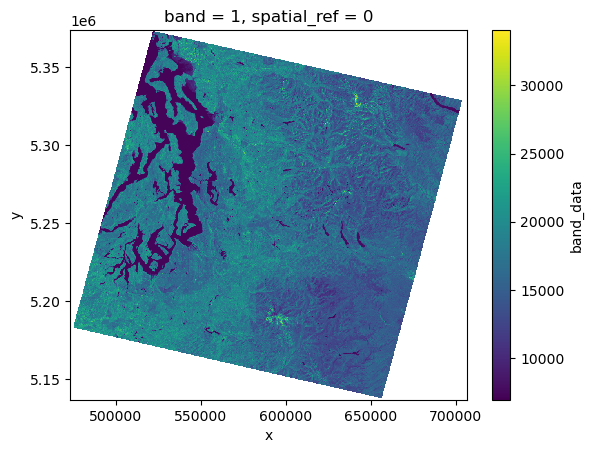

In [5]:
da.plot();

The `spatial_ref` coordinate has Coordinate Reference System (CRS) Information. This dataset is 'Universal Tranverse Mercator (UTM)'. Rioxarray has methods that can be accessed via the `.rio` attribute, for example to display the CRS (https://epsg.io/32610)

In [6]:
da.rio.crs

CRS.from_epsg(32610)

In [7]:
# reproject to lon/lat
daLL = da.rio.reproject('EPSG:4326')
daLL

<xarray.DataArray 'band_data' (band: 1, y: 802, x: 1171)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 -123.4 -123.4 -123.4 ... -120.2 -120.2 -120.2
  * y            (y) float64 48.51 48.51 48.51 48.51 ... 46.36 46.36 46.36 46.36
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Point

Note: the dimensions have the same names ('x','y'). But now the coordinate *values* are 'longitude', 'latitude' instead of 'easting' and 'northing'. Also because we've reprojected the orginal data onto a new grid, the total size of the array has changed from (987, 972) to (802, 1171)

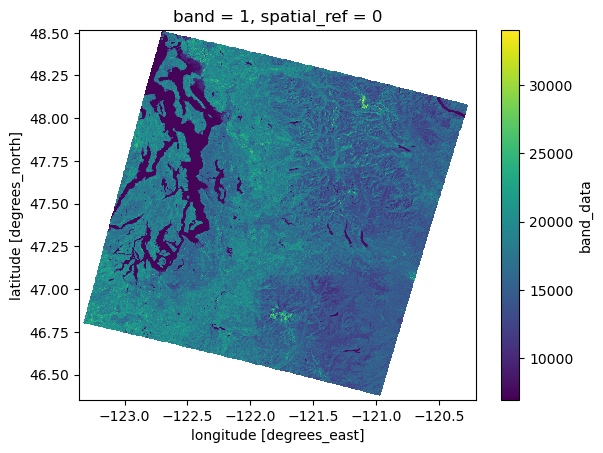

In [8]:
daLL.plot();

## Sampling

Xarray uses sampling based on either real-world coordinates (`.sel`) or row/col (`.isel`). This is similar to Pandas  `loc` or `.iloc` !

In [9]:
daLL.sel(y=47.0, x=-122.0, method='nearest') # Return a DataArray

<xarray.DataArray 'band_data' (band: 1)>
array([17740.], dtype=float32)
Coordinates:
    x            float64 -122.0
    y            float64 47.0
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Point

In [10]:
daLL.sel(y=47.0, x=-122.0, method='nearest').data # Return a numpy Array

array([17740.], dtype=float32)

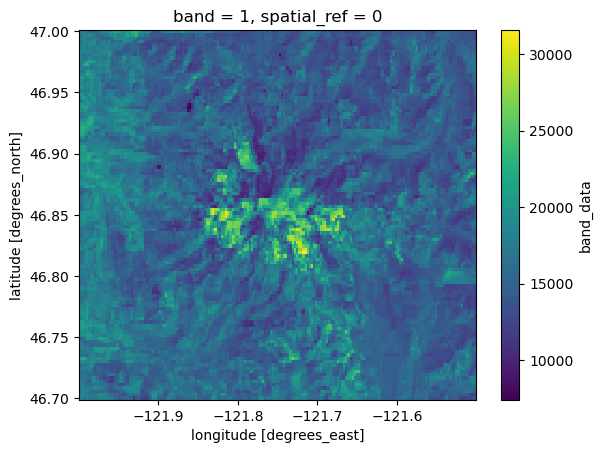

In [11]:
# Zoom in on Mt Rainier
daLL.sel(y=slice(47.0, 46.7), x=slice(-122.0, -121.5)).plot();

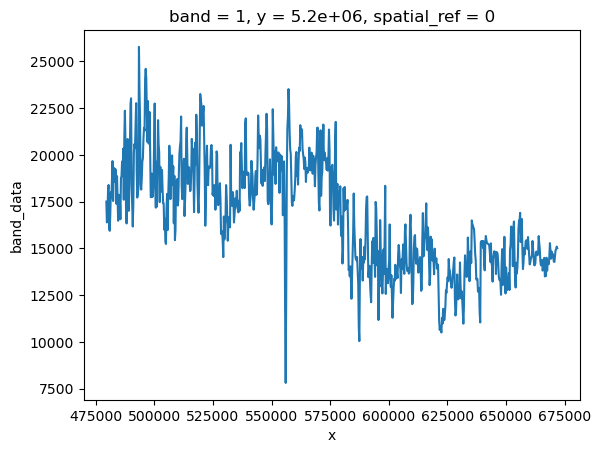

In [12]:
# Extract a profile (best in UTM for x-axis in meters)
da.sel(y=5.2e6, method='nearest').plot();

## Save a copy

Let's say we want to save a copy of our cropped value to use later, Rioxarray allows us to write to varies formats. Geotiff is the default:

In [13]:
daCrop = daLL.sel(y=slice(47.0, 46.7), x=slice(-122.0, -121.5))
daCrop.rio.to_raster('mt_rainier.tif')

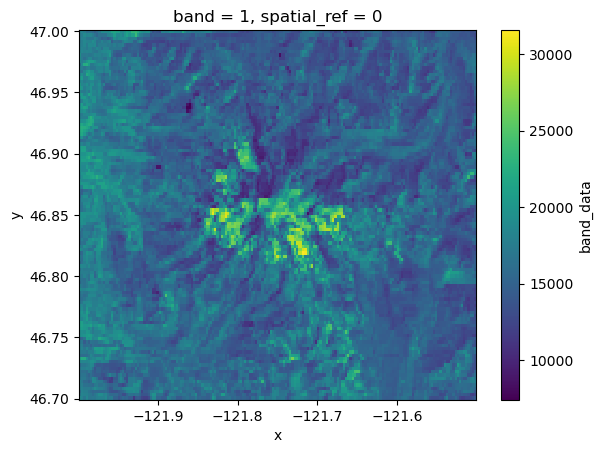

In [14]:
xr.open_dataarray('mt_rainier.tif', engine='rasterio').plot();

## TODO:

* DataSet for NDVI
* Full Resolution
* Planetary COmputer for Timeseries